In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('multi_classification_train.csv')
data.head()

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Class
0,1,-90.532634,-66.953472,79.261856,-111.800554,126.403549,111.509348,207.728953,-26.600556,-106.229324,...,148.391734,77.835738,-10.728207,1.100625,1.035362,-87.010809,-16.242297,-32.074925,-17.666026,1
1,2,-103.156720,-16.070400,87.819228,12.614599,51.347780,67.483725,40.269172,51.442254,-151.486693,...,29.009475,3.995786,-10.861630,-142.605726,-25.924592,-86.755351,-36.479749,-130.246619,-44.143652,2
2,3,24.326153,-92.098078,82.238354,-56.795879,85.203996,127.916504,-90.080307,-128.124071,18.036020,...,111.810098,65.826018,-101.271203,-44.127749,-7.131464,-105.049759,-130.948256,-43.113523,-37.330448,4
3,4,-64.631737,-83.703583,84.135072,-5.516152,74.338494,112.630556,181.576798,-1.054023,60.469865,...,50.047108,100.439101,-117.842955,150.239788,-144.635542,-144.306209,-69.272905,-79.629675,-51.334456,2
4,5,-55.473830,-78.853237,88.129107,75.200543,76.991520,60.224711,-13.106559,-146.773016,-33.490566,...,85.988282,23.381960,11.876102,-188.296503,-80.323929,-56.757987,-20.314172,-42.625170,-24.102753,2


In [3]:
data = pd.read_csv("multi_classification_train.csv")

X = data.loc[:, "Feature_1":"Feature_20"].values
y = data["Class"].values

X, y

(array([[ -90.53263395,  -66.95347161,   79.26185595, ...,  -16.24229669,
          -32.07492465,  -17.66602617],
        [-103.15671956,  -16.07040001,   87.81922753, ...,  -36.47974913,
         -130.24661901,  -44.14365222],
        [  24.32615256,  -92.09807783,   82.23835394, ..., -130.94825564,
          -43.11352279,  -37.33044832],
        ...,
        [ -37.12290449,   -0.885023  ,   86.99002687, ...,  -41.19319101,
          -66.65209662,  -35.86556245],
        [ -81.06584735,   43.82958547,   87.79424775, ...,  -22.31197279,
          -56.10486356,  -71.17497908],
        [ -67.19757637,  -38.81837815,   88.86213941, ...,  -10.17967089,
         -127.6604871 ,  -58.59004816]]),
 array([1, 2, 4, ..., 1, 3, 2], dtype=int64))

spilliting data for cross validation and taking transpose 

In [4]:
train_size = int(0.8 * X.shape[0])

X_train = X[:train_size]
X_test  = X[train_size:]

y_train_labels = y[:train_size]
y_test_labels  = y[train_size:]

mean = X_train.mean(axis=0)
std  = X_train.std(axis=0)

X_train = (X_train - mean) / std
X_test  = (X_test - mean) / std

X_train = X_train.T     # (20, 38400)
X_test  = X_test.T      # (20, 9600)


Defining one hot encoding functions

In [5]:
num_classes = len(np.unique(y))

def one_hot(y, num_classes):
    m = y.shape[0]
    out = np.zeros((num_classes, m))
    out[y, np.arange(m)] = 1
    return out

y_train = one_hot(y_train_labels, num_classes)   # (num_classes, 38400)
y_test  = one_hot(y_test_labels, num_classes)    # (num_classes, 9600)


In [6]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)


X_train: (20, 38400)
y_train: (5, 38400)
X_test : (20, 9600)
y_test : (5, 9600)


one hot encoding of training output

In [7]:
n_x = X_train.shape[0]     # 20
n_h1 = 1024
n_h2 = 512
n_y = num_classes          # 5

w1 = np.random.randn(n_h1, n_x) * np.sqrt(2/n_x)
b1 = np.zeros((n_h1, 1))

w2 = np.random.randn(n_h2, n_h1) * np.sqrt(2/n_h1)
b2 = np.zeros((n_h2, 1))

w3 = np.random.randn(n_y, n_h2) * np.sqrt(2/n_h2)
b3 = np.zeros((n_y, 1))


Defining functions 

In [8]:
def cost_function(a3, y, lambd, w1, w2, w3):
    m = y.shape[1]
    eps = 1e-10
    cross_entropy = -np.sum(y * np.log(a3 + eps)) / m
    reg = (lambd/(2*m)) * (np.sum(w1**2) + np.sum(w2**2) + np.sum(w3**2))
    return cross_entropy + reg


In [9]:
def relu(z):
    return np.maximum(0, z)

def d_relu(z):
    return (z > 0).astype(np.float32)

def softmax(z):
    z = z - np.max(z, axis=0, keepdims=True)
    expZ = np.exp(z)
    return expZ / np.sum(expZ, axis=0, keepdims=True)


Iter 0: Cost=2.6097, Acc=18.87%
Iter 20: Cost=0.3802, Acc=90.50%
Iter 40: Cost=0.2791, Acc=93.96%
Iter 60: Cost=0.2489, Acc=94.89%
Iter 80: Cost=0.2319, Acc=95.47%
Iter 100: Cost=0.2193, Acc=95.81%
Iter 120: Cost=0.2089, Acc=96.08%
Iter 140: Cost=0.2000, Acc=96.31%
Iter 160: Cost=0.1921, Acc=96.48%
Iter 180: Cost=0.1849, Acc=96.59%


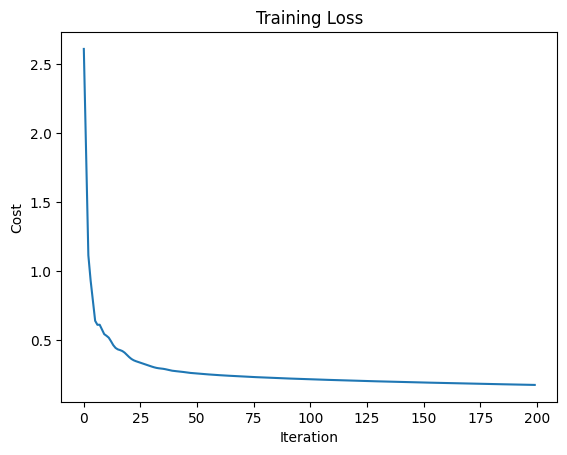

In [10]:
# Forward + Backward + Adam (Correct)

def compute_accuracy(a3, y_labels):
    preds = np.argmax(a3, axis=0)
    return np.mean(preds == y_labels) * 100

# Adam parameters
beta1, beta2 = 0.9, 0.999
eps = 1e-8
alpha_initial = 0.001
decay_rate = 0.96
decay_step = 100
lambd = 0.0001

# Adam moments
m_w1 = np.zeros_like(w1); v_w1 = np.zeros_like(w1)
m_w2 = np.zeros_like(w2); v_w2 = np.zeros_like(w2)
m_w3 = np.zeros_like(w3); v_w3 = np.zeros_like(w3)

m_b1 = np.zeros_like(b1); v_b1 = np.zeros_like(b1)
m_b2 = np.zeros_like(b2); v_b2 = np.zeros_like(b2)
m_b3 = np.zeros_like(b3); v_b3 = np.zeros_like(b3)

t = 0
iterations = 200
costs = []

for i in range(iterations):

    # Forward
    z1 = w1 @ X_train + b1
    a1 = relu(z1)

    z2 = w2 @ a1 + b2
    a2 = relu(z2)

    z3 = w3 @ a2 + b3
    a3 = softmax(z3)

    # Backward
    m = X_train.shape[1]
    dz3 = a3 - y_train

    dw3 = (dz3 @ a2.T)/m + lambd*w3
    db3 = np.sum(dz3, axis=1, keepdims=True)/m

    dz2 = (w3.T @ dz3) * d_relu(z2)
    dw2 = (dz2 @ a1.T)/m + lambd*w2
    db2 = np.sum(dz2, axis=1, keepdims=True)/m

    dz1 = (w2.T @ dz2) * d_relu(z1)
    dw1 = (dz1 @ X_train.T)/m + lambd*w1
    db1 = np.sum(dz1, axis=1, keepdims=True)/m

    # Adam update
    t += 1
    lr = alpha_initial * (decay_rate ** (t / decay_step))

    def adam_update(w, dw, m, v):
        m = beta1*m + (1-beta1)*dw
        v = beta2*v + (1-beta2)*(dw**2)
        m_hat = m / (1-beta1**t)
        v_hat = v / (1-beta2**t)
        w -= lr * m_hat / (np.sqrt(v_hat) + eps)
        return w, m, v

    w1, m_w1, v_w1 = adam_update(w1, dw1, m_w1, v_w1)
    b1, m_b1, v_b1 = adam_update(b1, db1, m_b1, v_b1)

    w2, m_w2, v_w2 = adam_update(w2, dw2, m_w2, v_w2)
    b2, m_b2, v_b2 = adam_update(b2, db2, m_b2, v_b2)

    w3, m_w3, v_w3 = adam_update(w3, dw3, m_w3, v_w3)
    b3, m_b3, v_b3 = adam_update(b3, db3, m_b3, v_b3)

    # cost
    c = cost_function(a3, y_train, lambd, w1, w2, w3)
    costs.append(c)

    if i % 20 == 0:
        acc = compute_accuracy(a3, y_train_labels)
        print(f"Iter {i}: Cost={c:.4f}, Acc={acc:.2f}%")


# ---------- PLOT ----------
plt.plot(costs)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Training Loss")
plt.show()



In [11]:
print(data.shape)
print(data.head())
print(data.tail())
print(data.isnull().sum())


(48000, 22)
   ID   Feature_1  Feature_2  Feature_3   Feature_4   Feature_5   Feature_6  \
0   1  -90.532634 -66.953472  79.261856 -111.800554  126.403549  111.509348   
1   2 -103.156720 -16.070400  87.819228   12.614599   51.347780   67.483725   
2   3   24.326153 -92.098078  82.238354  -56.795879   85.203996  127.916504   
3   4  -64.631737 -83.703583  84.135072   -5.516152   74.338494  112.630556   
4   5  -55.473830 -78.853237  88.129107   75.200543   76.991520   60.224711   

    Feature_7   Feature_8   Feature_9  ...  Feature_12  Feature_13  \
0  207.728953  -26.600556 -106.229324  ...  148.391734   77.835738   
1   40.269172   51.442254 -151.486693  ...   29.009475    3.995786   
2  -90.080307 -128.124071   18.036020  ...  111.810098   65.826018   
3  181.576798   -1.054023   60.469865  ...   50.047108  100.439101   
4  -13.106559 -146.773016  -33.490566  ...   85.988282   23.381960   

   Feature_14  Feature_15  Feature_16  Feature_17  Feature_18  Feature_19  \
0  -10.728207  

In [17]:
def predict(X, w1, w2, w3, b1, b2, b3):
    z1 = w1 @ X + b1
    a1 = relu(z1)
    z2 = w2 @ a1 + b2
    a2 = relu(z2)
    z3 = w3 @ a2 + b3
    a3 = softmax(z3)
    return np.argmax(a3, axis=0)

preds = predict(X_test, w1, w2, w3, b1, b2, b3)
test_acc = np.mean(preds == y_test_labels) * 100
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 96.17%


In [18]:
def f1_score_weighted(y_true, y_pred, n_classes):
    eps = 1e-9

    f1_scores = np.zeros(n_classes)
    support = np.zeros(n_classes)

    for c in range(n_classes):

        # True Positives
        TP = np.sum((y_true == c) & (y_pred == c))

        # False Positives
        FP = np.sum((y_true != c) & (y_pred == c))

        # False Negatives
        FN = np.sum((y_true == c) & (y_pred != c))

        # Precision, Recall
        precision = TP / (TP + FP + eps)
        recall    = TP / (TP + FN + eps)

        # F1 score for class c
        f1_scores[c] = 2 * precision * recall / (precision + recall + eps)

        # Support = number of true samples in class c
        support[c] = np.sum(y_true == c)

    # Weighted average
    return np.sum(f1_scores * support) / (np.sum(support) + eps)


In [19]:
data_test = pd.read_csv("multi_classification_test.csv")

# Extract features exactly like training
x_test = data_test.loc[:, "Feature_1":"Feature_20"].values

# Normalize using TRAINING mean/std
x_test = (x_test - mean) / std

# Transpose for NN format
x_test = x_test.T   # (20, m_test)

# Predict
y_pred = prediction(x_test, w1, w2, w3, b1, b2, b3)

print(y_pred)
print("Shape:", y_pred.shape)


[3 1 1 ... 3 4 1]
Shape: (12000,)
